In [1]:
# Let's create a multiple linear regression model that can predict interest rates

In [2]:
# Import our dependencies
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import statsmodels.api as sm
import pandas as pd
import tensorflow as tf

#  Import and read the data.
import pandas as pd 
df = pd.read_csv("mortgage_interest_rates_gpt.csv")
df.head()

,Loan Amount,Credit Score,Property Value,Loan-to-Value Ratio,Loan Term (years),Employment Length,Location,Loan Type,Property Type,State,Interest Rate,Debt-To-Income DTI,Down Payment $,Income,Ocuppancy Type
0,370196,691,598519,0.726291,15,1-3 years,Suburban,Fixed,Townhouse,GA,6.84,34,96659,319164,Investment
1,383655,850,334839,0.694620,40,< 1 year,Suburban,Adjustable,Townhouse,IL,5.62,39,74991,299621,Investment
2,431526,675,487779,0.703256,20,3-5 years,Urban,Fixed,Multi Family,NC,6.71,45,69144,132666,Investment
3,439937,831,372338,0.575099,30,5-10 years,Suburban,Fixed,Single Family,PA,5.14,19,19053,115457,Primary
4,254104,839,634963,0.848023,40,5-10 years,Suburban,Adjustable,Townhouse,FL,5.04,49,68221,294726,Secondary


In [3]:
# What does our data look like?
print(df.dtypes)

Loan Amount              int64
Credit Score             int64
Property Value           int64
Loan-to-Value Ratio    float64
Loan Term (years)        int64
Employment Length       object
Location                object
Loan Type               object
Property Type           object
State                   object
Interest Rate          float64
Debt-To-Income DTI       int64
Down Payment $           int64
Income                   int64
Ocuppancy Type          object
dtype: object


In [4]:
# Reduce employment length to 3 options - doing our best to reduce features
df["Employment Length"] = df["Employment Length"].replace({'< 1 year': '<3 years', '1-3 years': '<3 years',
                                                           '3-5 years': '3-10 years', '5-10 years': '3-10 years'})

In [5]:
# Make sure you did it correctly!
df["Employment Length"].unique()

array(['<3 years', '3-10 years', '10+ years'], dtype=object)

In [6]:
# Convert loan-to-value ration to numerical
# Multiple by 100 so it's not such a low number

df["Loan-to-Value Ratio"] = df["Loan-to-Value Ratio"]*100
df["Loan-to-Value Ratio"] = df["Loan-to-Value Ratio"].astype('int64')

In [7]:
# Drop the state column - to many unique values, but too few unique values for binning
# Be gone, states!

df = df.drop(["State"], axis=1)
df.head()

,Loan Amount,Credit Score,Property Value,Loan-to-Value Ratio,Loan Term (years),Employment Length,Location,Loan Type,Property Type,Interest Rate,Debt-To-Income DTI,Down Payment $,Income,Ocuppancy Type
0,370196,691,598519,72,15,<3 years,Suburban,Fixed,Townhouse,6.84,34,96659,319164,Investment
1,383655,850,334839,69,40,<3 years,Suburban,Adjustable,Townhouse,5.62,39,74991,299621,Investment
2,431526,675,487779,70,20,3-10 years,Urban,Fixed,Multi Family,6.71,45,69144,132666,Investment
3,439937,831,372338,57,30,3-10 years,Suburban,Fixed,Single Family,5.14,19,19053,115457,Primary
4,254104,839,634963,84,40,3-10 years,Suburban,Adjustable,Townhouse,5.04,49,68221,294726,Secondary


In [ ]:
# Let's See what our data looks like
# Alrighty, let's try to answer some questions:

# How is our data distributed?
# Are there any confounding variables?
# Are there any outliers

In [8]:
# Let's separate all of our numerical features so we can answer the previous questions

df_numeric = df[["Loan Amount", "Credit Score", "Property Value", "Loan-to-Value Ratio", "Debt-To-Income DTI", "Down Payment $", "Income", "Interest Rate"]]

# There's probably an easier way to do that, but you didn't get enough sleep last night
# because of the time change, so who cares?
# but make sure you did it right - just to be sure you don't need another cup of coffee

df_numeric.head()

,Loan Amount,Credit Score,Property Value,Loan-to-Value Ratio,Debt-To-Income DTI,Down Payment $,Income,Interest Rate
0,370196,691,598519,72,34,96659,319164,6.84
1,383655,850,334839,69,39,74991,299621,5.62
2,431526,675,487779,70,45,69144,132666,6.71
3,439937,831,372338,57,19,19053,115457,5.14
4,254104,839,634963,84,49,68221,294726,5.04


In [52]:
# Ok so what are we working with?
df_numeric.describe()

,Loan Amount,Credit Score,Property Value,Loan-to-Value Ratio,Debt-To-Income DTI,Down Payment $,Income,Interest Rate
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,304080.992000,746.99000,454892.489000,74.833000,30.003000,55008.850000,229385.906000,6.13392
std,114046.040897,60.18929,143475.598092,14.372532,12.043755,25812.529669,73110.801266,2.01181
min,100577.000000,640.00000,200035.000000,50.000000,10.000000,10178.000000,100148.000000,0.92000
25%,207962.000000,696.75000,331336.000000,62.000000,20.000000,32193.750000,166694.250000,4.74000
50%,308825.500000,749.00000,458413.500000,75.000000,30.000000,54838.500000,231451.500000,6.31000
75%,398993.750000,798.00000,577470.500000,87.000000,41.000000,76780.250000,296237.000000,7.57000
max,499803.000000,850.00000,699880.000000,99.000000,50.000000,99913.000000,349435.000000,10.56000


array([[<AxesSubplot:title={'center':'Loan Amount'}>,
        <AxesSubplot:title={'center':'Credit Score'}>,
        <AxesSubplot:title={'center':'Property Value'}>],
       [<AxesSubplot:title={'center':'Loan-to-Value Ratio'}>,
        <AxesSubplot:title={'center':'Debt-To-Income DTI'}>,
        <AxesSubplot:title={'center':'Down Payment $'}>],
       [<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Interest Rate'}>, <AxesSubplot:>]],
      dtype=object)

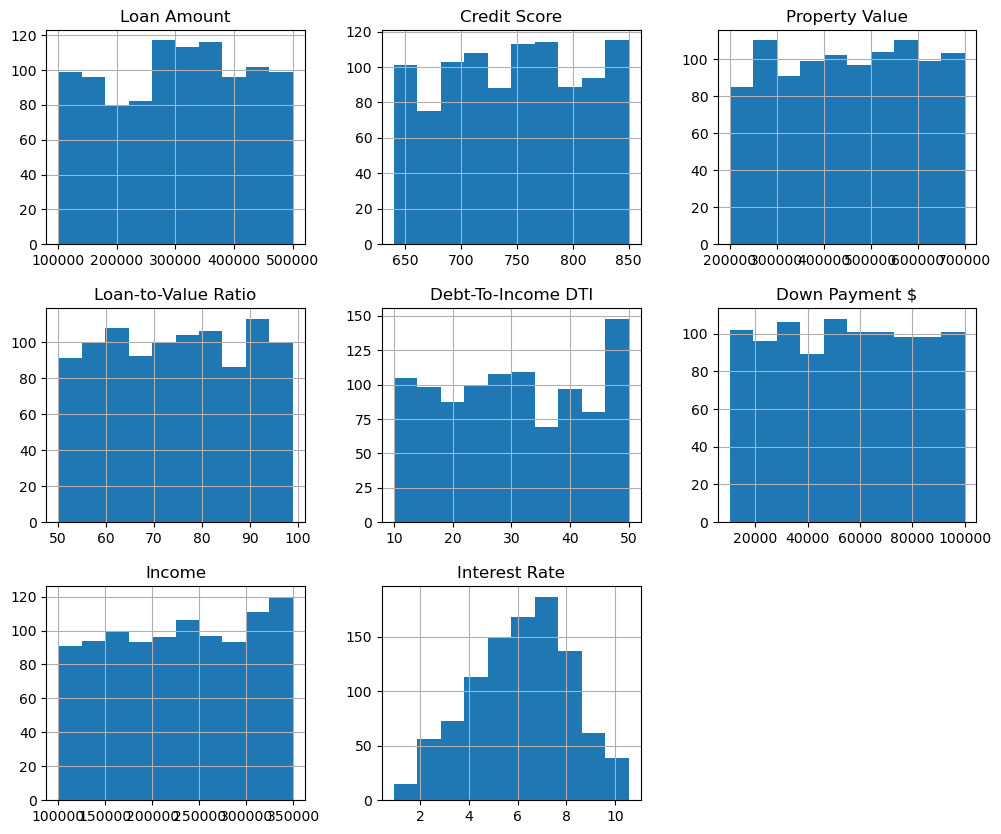

In [9]:
# How is your feature data distributed?
df_numeric.hist(figsize = (12,10))

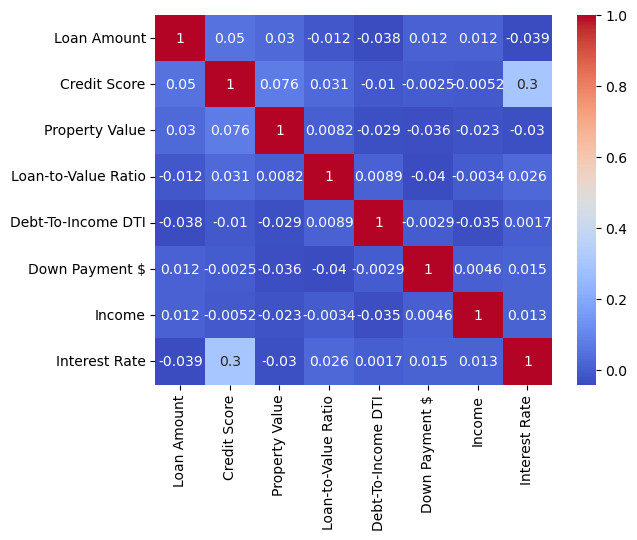

In [10]:
# How do the features correlate with one another?
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_numeric.corr()

# plot the heatmap
plt = sns.heatmap(corr, annot=True, cmap='coolwarm')


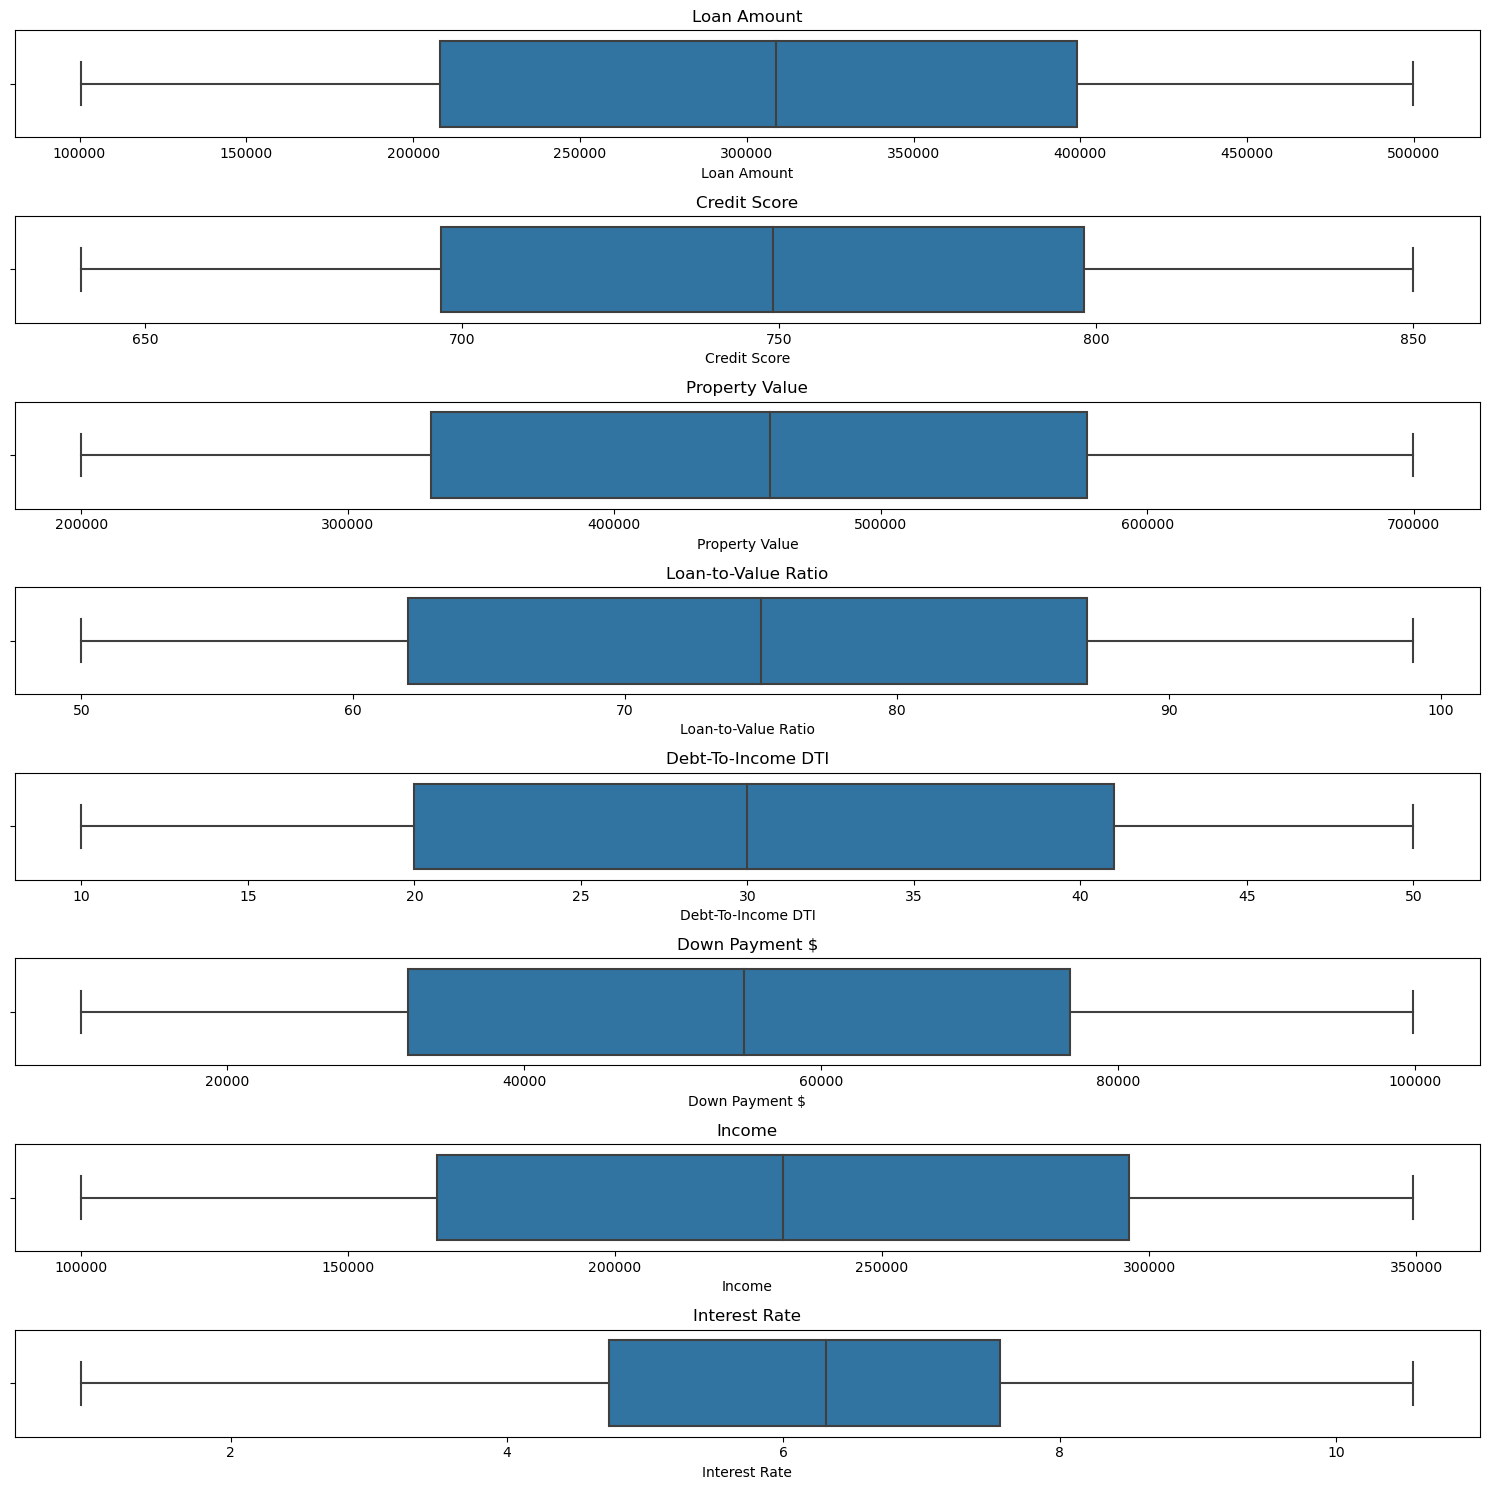

In [51]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a figure with subplots for each column in the DataFrame
fig, axs = plt.subplots(len(df_numeric.columns),1, figsize=(15,15), sharey=False, sharex=False)

# Loop over each column in the DataFrame and create a boxplot on the corresponding subplot
for i, col in enumerate(df_numeric.columns):
    sns.boxplot(x=df_numeric[col], ax=axs[i], orient = 'h')
    axs[i].set_title(col)
    
plt.tight_layout()

In [53]:
# Generate our categorical variable lists
categories = df.dtypes[df.dtypes == "object"].index
categories

Index(['Employment Length', 'Location', 'Loan Type', 'Property Type',
       'Ocuppancy Type'],
      dtype='object')

In [54]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[categories]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(categories)
encode_df.head()

C:\Users\Soldo\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Employment Length_10+ years,Employment Length_3-10 years,Employment Length_<3 years,Location_Rural,Location_Suburban,Location_Urban,Loan Type_Adjustable,Loan Type_Fixed,Property Type_Condo,Property Type_Multi Family,Property Type_Single Family,Property Type_Townhouse,Ocuppancy Type_Investment,Ocuppancy Type_Primary,Ocuppancy Type_Secondary
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [55]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df, left_index=True, right_index=True)
df = df.drop(columns = categories)
df

,Loan Amount,Credit Score,Property Value,Loan-to-Value Ratio,Loan Term (years),Interest Rate,Debt-To-Income DTI,Down Payment $,Income,Employment Length_10+ years,...,Location_Urban,Loan Type_Adjustable,Loan Type_Fixed,Property Type_Condo,Property Type_Multi Family,Property Type_Single Family,Property Type_Townhouse,Ocuppancy Type_Investment,Ocuppancy Type_Primary,Ocuppancy Type_Secondary
0,370196,691,598519,72,15,6.84,34,96659,319164,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,383655,850,334839,69,40,5.62,39,74991,299621,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,431526,675,487779,70,20,6.71,45,69144,132666,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,439937,831,372338,57,30,5.14,19,19053,115457,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,254104,839,634963,84,40,5.04,49,68221,294726,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,421309,817,589524,63,20,6.78,41,86893,325064,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
996,266645,838,524588,97,40,3.24,15,77735,255500,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
997,101713,679,449416,89,25,6.28,34,71959,207923,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
998,402599,808,662640,58,20,9.45,47,98092,195512,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [56]:
# Split our preprocessed data into our features and target arrays
X = df.drop(columns = "Interest Rate")
y = df["Interest Rate"]

In [57]:
from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=78)

In [58]:
# Create a MinMaxScaler instance
# use because we know the minimum and maximum values of our data
# and there are no outliers
scaler = MinMaxScaler()

# Fit the scaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [62]:
# Using statsmodels
# adding a constant to get an intercept
x = sm.add_constant(X_train_scaled) 

# Fit the regression line using Ordinary Least Squares - 'OLS'
model = sm.OLS(y_train, x).fit()

In [65]:
results = model.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:          Interest Rate   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     182.9
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          3.38e-256
Time:                        16:59:19   Log-Likelihood:                -956.99
No. Observations:                 750   AIC:                             1952.
Df Residuals:                     731   BIC:                             2040.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7572      0.060     46.240      0.0